In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel


from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time
import h5py

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Glen's beam from Yunhai's 3D paper

In [2]:
# Glen's beam, which comes from Yunhai's 3D CSR paper!

gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34 # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Nb = 6.25e9
Q = e_charge * Nb


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2



# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread


# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

### Yunhai's beam for transient wakes

In [4]:
# Yunhai's beam for transient wakes

gamma = 5000
rho = 1.5 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m

sigma_x = 50e-6
sigma_xp = emit_x / sigma_x
sigma_y = 0
sigma_yp = 0
sigma_z  = 50e-6
sigma_delta = 0

beam = np.zeros((6, Np))
beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2

## code

In [6]:
# Copy of a section from kick2.py

from csr2d.convolution import fftconvolve2

from csr2d.kick2 import green_meshes_case_D
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

def compute_transient_wake_case_D(
    z_b,x_b,weight,*,
    gamma=None, rho=None, lamb=None, phi_m=None, x_observe=None,
    nz=100,nx=100,xlim=None,zlim=None,
    reuse_psi_grids=False, psi_s_grid_old=None, psi_x_grid_old=None, map_f=map,
    species="electron", imethod='map_coordinates', debug=False):
    
    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)

    beta = np.sqrt(1 - 1 / gamma**2)

    t3 = time.time()

    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        #psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
        Es_grid, zvec2, xvec2 = green_meshes_case_D(nz, nx, dz, dx, rho=rho, beta=beta, lamb=lamb) 
    
    if debug:
        t4 = time.time()
        print("Computing case D field grids take:", t4 - t3, "s")

    # Compute the wake via 2d convolution
    # ============================================   
    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi_m + lamb - beta*np.sqrt( lamb**2 + temp**2 + 4*(1+temp)*np.sin(phi_m/2)**2 + 2*lamb*np.sin(phi_m)))
    zo_vec = rho*(lamb - beta*np.sqrt( lamb**2 + temp**2 ))
    
    # Computing the integral term of case D
    # Want "True" if (z > zi) OR (z < zo), where the potential values are set to ZERO
    condition_grid = np.array([(zvec2 > zi_vec[i]) | (zvec2 < zo_vec[i]) for i in range(len(xvec2))])
    Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    #psi_x_grid_bounded = np.where(condition_grid.T, 0, psi_x_grid)
    conv_s = fftconvolve2(lambda_grid_filtered, Es_grid_bounded)[0]   # No prime for case D!
    Ws_grid = (beta**2 / rho**2) * (conv_s) * (dz * dx)
    
    if debug:
        t5 = time.time()
        print("Convolution for one x_observe takes:", t5 - t4, "s")

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    print('x_observe_index :', x_observe_index )
    
    return zvec2, xvec2, Es_grid
    #return zvec, xvec, Ws_grid[:,x_observe_index]
    #return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, lambda_grid_filtered_prime, psi_s_grid, Ws_grid, dz, dx

In [15]:
zvec2, xvec2, Es_grid = compute_transient_wake_case_D(beam[4,:], beam[0,:], 
                                     charges, gamma=gamma, rho=rho, lamb=0.1, phi_m=0.5/rho, x_observe=0,
                                     nz=600, nx=600,
                                     map_f = map, debug=True)

Depositing particles takes: 0.01760554313659668 s
Computing case D field grids take: 1.8790349960327148 s
Convolution for one x_observe takes: 0.2046980857849121 s
x_observe_index : 308


Text(0.5, 0.92, 'psi_s at the first step of chicane')

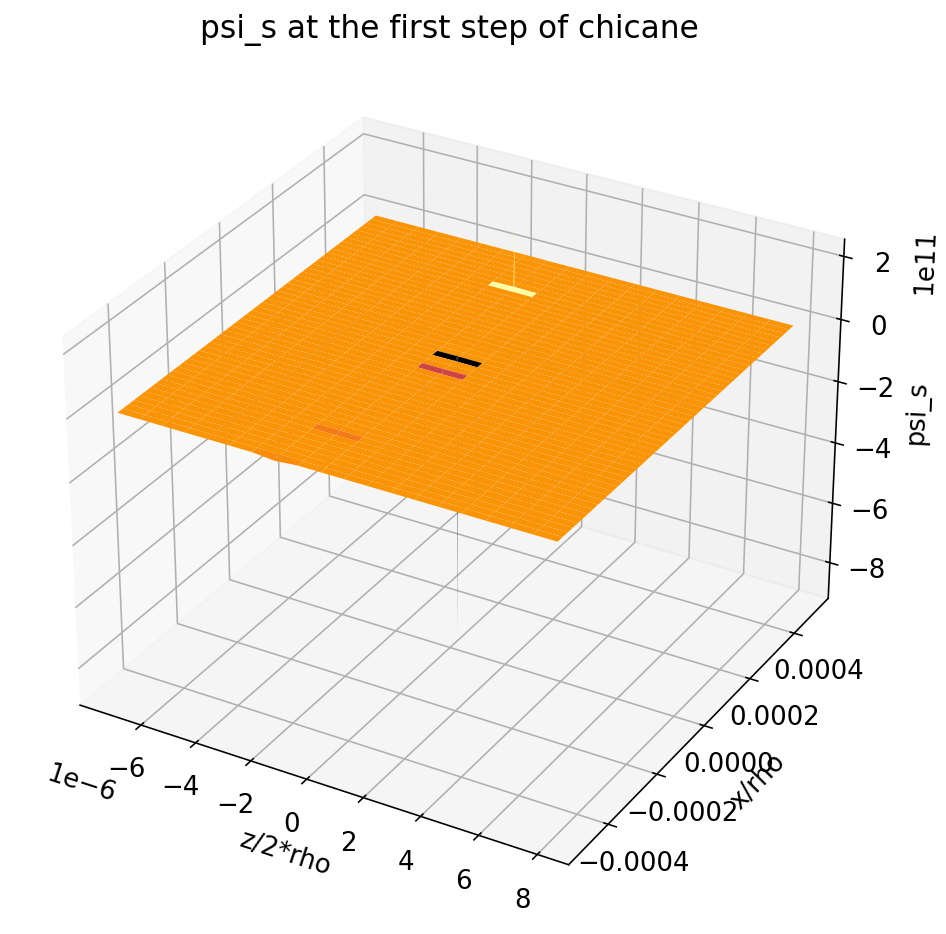

In [23]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec2, xvec2, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
#ax.plot_surface(Z,X, Es_grid, cmap='inferno')
ax.plot_surface(Z[590:610,:],X[590:610,:], Es_grid[590:610,:], cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

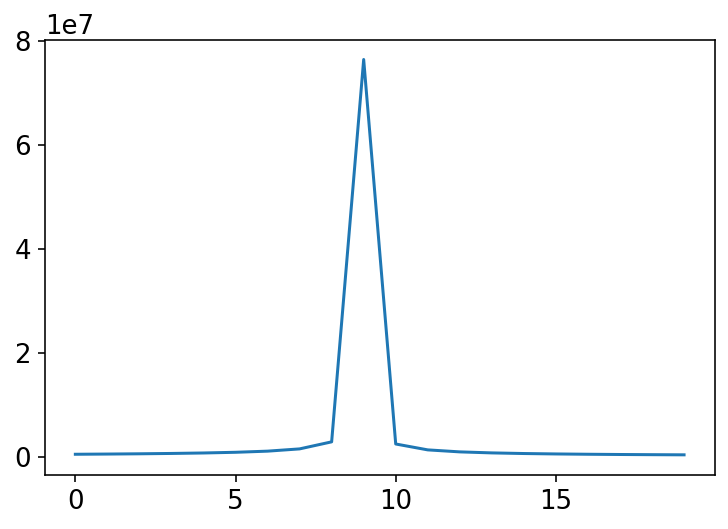

In [25]:
plt.plot(Es_grid[590:610,700])

In [10]:
ffD = lambda lamb : compute_transient_wake_case_D(beam[4,:], beam[0,:], 
                                     charges, gamma=gamma, rho=rho, lamb=lamb, phi_m=0.5/rho, x_observe=0,
                                     nz=100, nx=100,
                                     map_f = map, debug=True)

Depositing particles takes: 0.014086723327636719 s
Computing case D field grids take: 0.053476810455322266 s
Convolution for one x_observe takes: 0.0058650970458984375 s
x_observe_index : 51
Depositing particles takes: 0.014568090438842773 s
Computing case D field grids take: 0.05076456069946289 s
Convolution for one x_observe takes: 0.005034208297729492 s
x_observe_index : 51
Depositing particles takes: 0.013295888900756836 s
Computing case D field grids take: 0.04741477966308594 s
Convolution for one x_observe takes: 0.005234718322753906 s
x_observe_index : 51
Depositing particles takes: 0.01328277587890625 s
Computing case D field grids take: 0.04573965072631836 s
Convolution for one x_observe takes: 0.004785299301147461 s
x_observe_index : 51


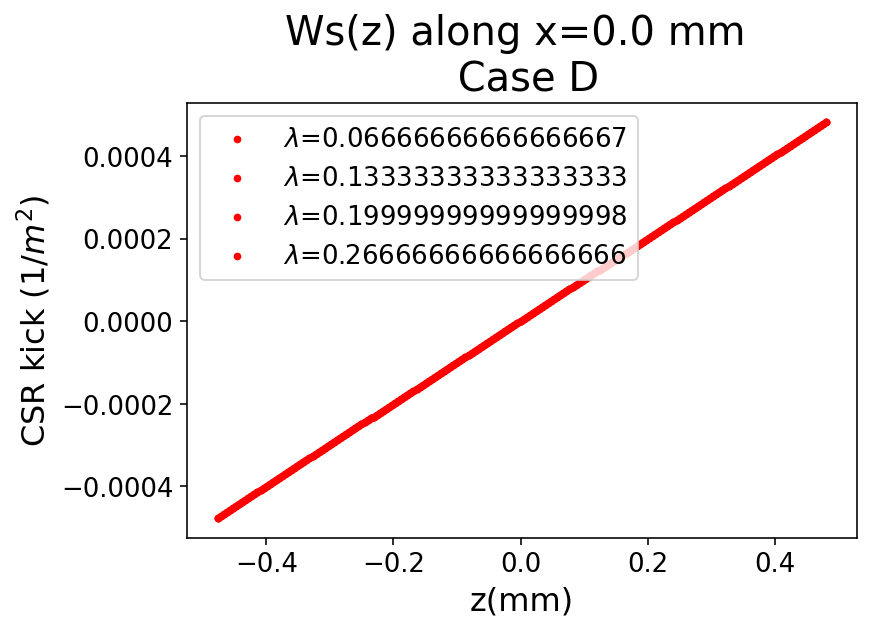

In [14]:
x_observe = 0.0

ffD = lambda lamb : compute_transient_wake_case_D(beam[4,:], beam[0,:], 
                                     charges, gamma=gamma, rho=rho, lamb=lamb, phi_m=0.5/rho, x_observe=0,
                                     nz=100, nx=100,
                                     map_f = map, debug=True)
lamb_vec = [0.1/rho,0.2/rho,0.3/rho,0.4/rho]
wake_list = list(map(ffD, lamb_vec))

zvec = wake_list[0][0]

plt.scatter(zvec*10**3, wake_list[0][0], color='red', label='$\lambda$='+str(lamb_vec[0]), s=8 )
plt.scatter(zvec*10**3, wake_list[1][0], color='red', label='$\lambda$='+str(lamb_vec[1]), s=8 )
plt.scatter(zvec*10**3, wake_list[2][0], color='red', label='$\lambda$='+str(lamb_vec[2]), s=8 )
plt.scatter(zvec*10**3, wake_list[3][0], color='red', label='$\lambda$='+str(lamb_vec[3]), s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case D',  fontsize=20)
plt.legend()

In [36]:
wake_list[0].shape

(100,)

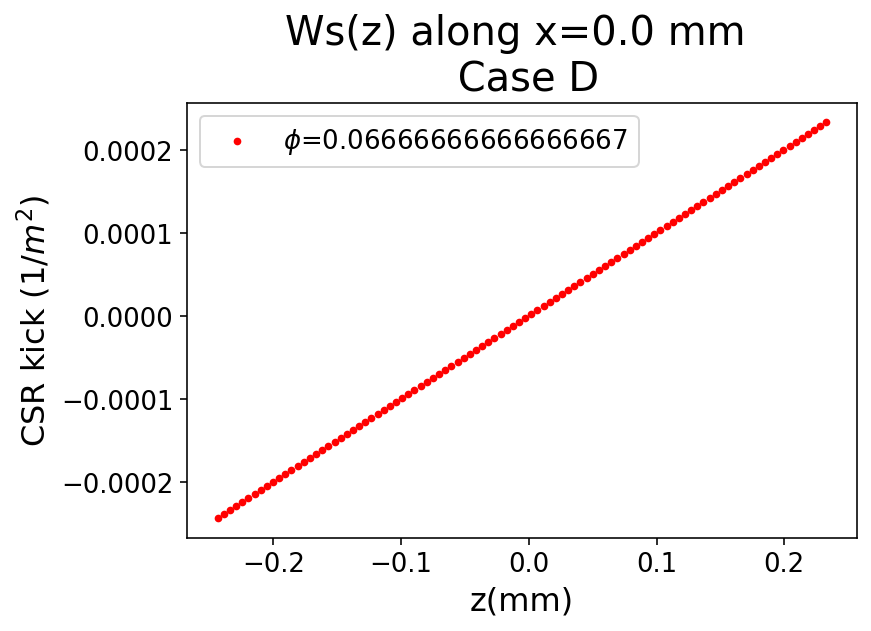

In [44]:
zvec = wake_list[0][0]

plt.scatter(zvec*10**3, wake_list[0][0], color='red', label='$\phi$='+str(lamb_vec[0]), s=8 )


plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case D',  fontsize=20)
plt.legend()

# Below are records from case B

In [143]:
x_observe = 0.0

#ffA = lambda a : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
#    gamma=gamma, rho=rho, phi = a, x_observe = 0,
#    nz=200, nx=150, debug=True)

ffB = lambda a : compute_transient_wake_case_B(a, x_observe, zvec2, xvec2, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid, ploton=False)
phi_vec = [0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
#phi_vec = [0.04, 0.06, 0.08, 0.12, 0.16, 0.2, 0.24]

phi_vec = [0.04, 0.08, 0.12, 0.16, 0.2, 0.24]
wake_list = list(map(ffB, phi_vec))

x_observe_index : 77
x_observe_index : 77
x_observe_index : 77
x_observe_index : 77
x_observe_index : 77
x_observe_index : 77


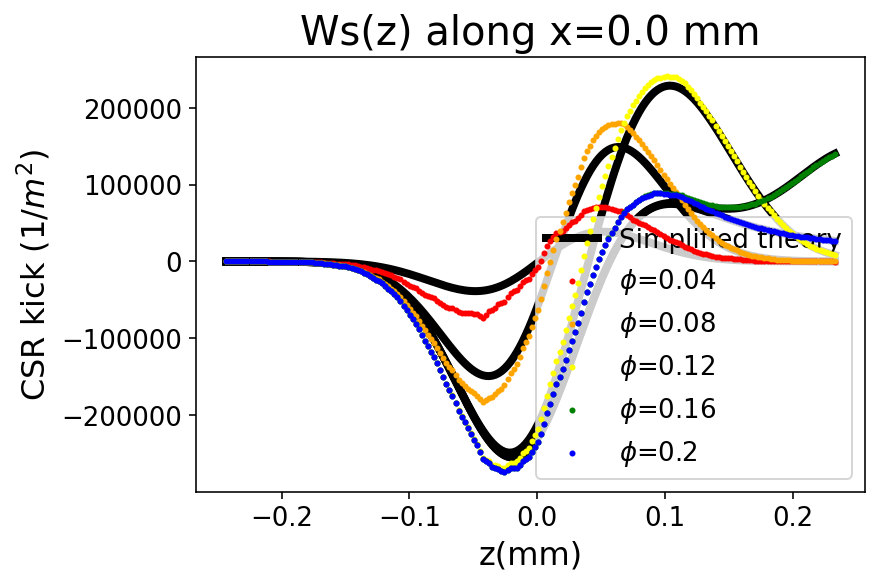

In [147]:
plt.scatter(zvec*10**3,wake_list[0][0], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4 )
plt.scatter(zvec*10**3,wake_list[1][0], color='orange', label='$\phi$='+str(phi_vec[1]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[2][0], color='yellow', label='$\phi$='+str(phi_vec[2]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[3][0], color='green', label='$\phi$='+str(phi_vec[3]), zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][0], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4   )
#plt.scatter(zvec*10**3,wake_list[5][0], color='purple', label='$\phi$='+str(phi_vec[5]), zorder=10, s=4  )

plt.plot(zvec*1e3, Wss_list1, color = 'black', linewidth=4, label = 'Simplified theory')
plt.plot(zvec*1e3, Wss_list2, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list3, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list4, color = 'black', linewidth=4)
plt.plot(zvec*1e3, Wss_list5, color = 'black', linewidth=4)
#plt.plot(zvec*1e3, Wss_list6, color = 'black', linewidth=4)

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

In [97]:
def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def lamb_1d_prime(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2) * (-z / sigma_z**2)
def plot_caseB_theory(phi, color, label=None):
    plt.plot(zvec*1e3, -4/phi/rho * lamb_1d( zvec - rho*phi**3/24), color = color, linewidth=4, label = label)

In [144]:
from scipy import integrate

def get_Wss(zo):
    w_ss = lambda z: -2/(3*rho**2)**(1/3)*lamb_1d_prime(z)/(zo - z)**(1/3)
    return integrate.quad(w_ss, zo - rho*phi**3/24, zo)[0]

phi = phi_vec[0]
Wss_list1 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[1]
Wss_list2 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[2]
Wss_list3 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[3]
Wss_list4 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[4]
Wss_list5 = np.array(list(map(get_Wss, zvec)))
phi = phi_vec[5]
Wss_list6 = np.array(list(map(get_Wss, zvec)))

x_observe_index : 77


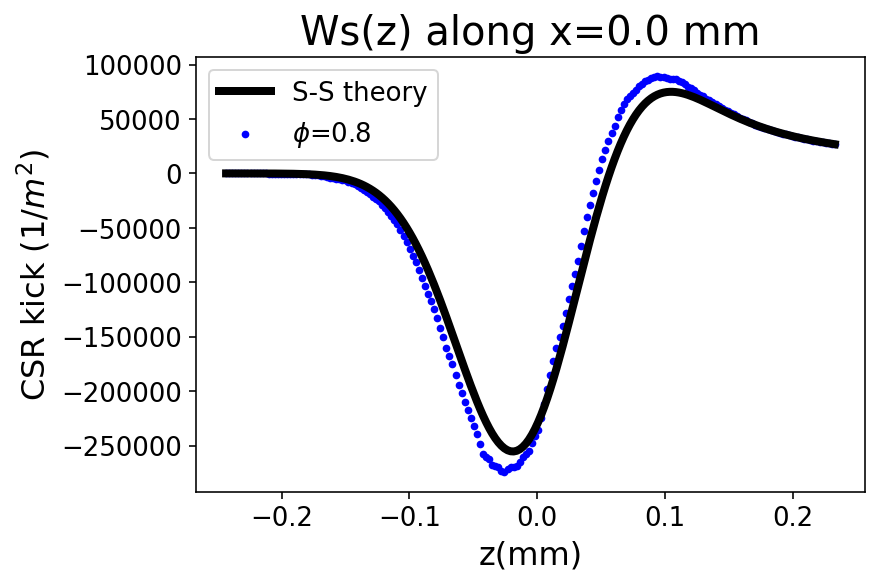

In [126]:
# S-S wake
phi_vec = [0.80]
wake_list = list(map(ffB, phi_vec))

plt.scatter(zvec*10**3,wake_list[0][0], color='blue', label='$\phi$='+str(phi_vec[0]), s=8    )

plt.plot(zvec*1e3, Wss_list, color = 'black', linewidth=4, label = 'S-S theory')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm',  fontsize=20)
plt.legend()

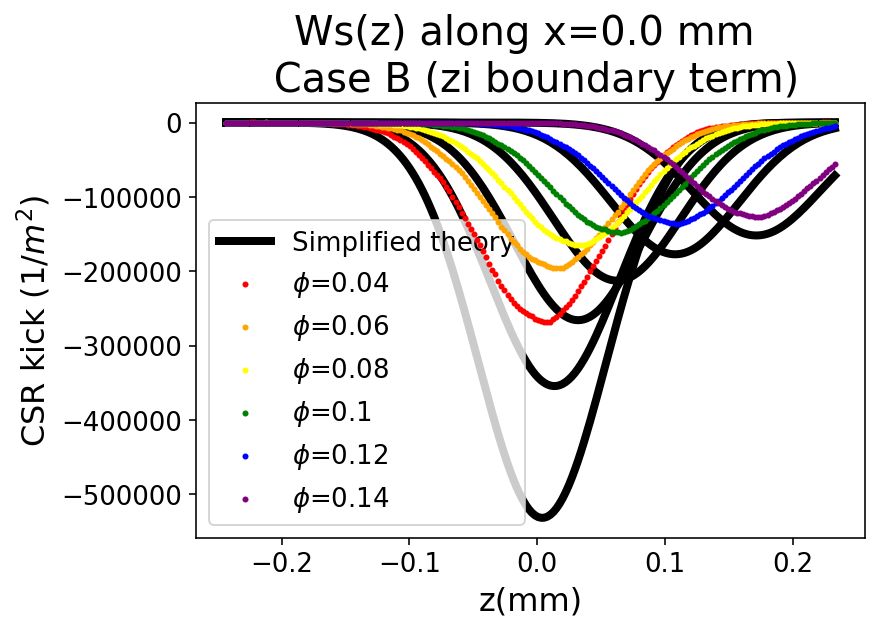

In [94]:
plt.scatter(zvec*10**3,wake_list[0][1], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3,wake_list[1][1], color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[2][1], color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[3][1], color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_list[4][1], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_list[5][1], color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )


plot_caseB_theory(phi_vec[0], 'black', 'Simplified theory')
plot_caseB_theory(phi_vec[1], 'black')
plot_caseB_theory(phi_vec[2], 'black')
plot_caseB_theory(phi_vec[3], 'black')
plot_caseB_theory(phi_vec[4], 'black')
plot_caseB_theory(phi_vec[5], 'black')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case B (zi boundary term)',  fontsize=20)
plt.legend()

In [177]:
@np.vectorize
def alpha_exact(z, x, beta2):
    """
    Exact alpha calculation using numerical root finding.
    
    For testing only!
    
    Eq. (23) from Ref[1]
    """
    beta = np.sqrt(beta2)
    f = lambda a: a - beta/2*np.sqrt(x**2 + 4*(1+x)*np.sin(a)**2 ) - z
    
    res = scipy.optimize.root_scalar(f, bracket=(-1,1))
    
    return res.root

In [262]:

#from numba import vectorize, float64, njit
#@vectorize([float64(float64, float64, float64, float64)])

@np.vectorize
def alpha_exact_case_D(z, x, lamb, beta2):
    """
    Exact alpha calculation using numerical root finding.
    
    For testing only!
    
    Eq. (23) from Ref[1]
    """
    beta = np.sqrt(beta2)
    f = lambda a: a + 1/2 * (lamb - beta*np.sqrt(lamb**2 + x**2 + 4*(1+x)*np.sin(a)**2 + 2*lamb*np.sin(2*a)) - z)
    
    res = scipy.optimize.root_scalar(f, bracket=(-1,1))
    
    return res.root

In [ ]:
zz = lambda a: a + 1/2 * lamb - beta*np.sqrt(lamb**2 + x**2 + 4*(1+x)*np.sin(a)**2 + 2*lamb*np.sin(2*a))

In [ ]:
f = lambda a: a + 1/2 * lamb - beta*np.sqrt(lamb**2 + x**2 + 4*(1+x)*np.sin(a)**2 + 2*lamb*np.sin(2*a)) - z

In [254]:
@np.vectorize
def alpha_case_B(z, x, beta2):
    """
    Exact alpha calculation using numerical root finding.
    
    For testing only!
    
    Eq. (23) from Ref[1]
    """
    C = 3*( 1 - beta2 - beta2*x ) / (beta2*(1+x))
    D = -6*z/(beta2*(1+x))
    E = 3*(4*z**2 - beta2*x**2)/(4*beta2*(1+x))
    
    f = lambda a: a**4 + C*a**2 + D*a + E
    g = lambda a: a**2
    #res = scipy.optimize.root_scalar(g, bracket=(-1,1))
    #res = scipy.optimize.root_scalar(g, x0=0) 
    #return res.root
    
    #return np.real(np.roots([1,0,C,D,E])[0])
    return np.roots([1,0,C,D,E])[0]

In [166]:
np.roots([1,-5,6])

array([3., 2.])

In [187]:
zm, xm = np.meshgrid(zvec, xvec, indexing="ij")

In [243]:
alpha_exact(-2e-4, 1e-5, 0.9999999)

array(-9.99372529e-05)

In [244]:
alpha_case_B(-2e-4, 1e-5, 0.9999999)

array([-1.06325393e-01+0.j        ,  5.32126652e-02+0.09194802j,
        5.32126652e-02-0.09194802j, -9.99372529e-05+0.j        ])

In [ ]:
zv = 

In [234]:
alpha_exact_case_D(2e-4, 1e-5, 0.03, 0.9999999)

array(0.07363681)

In [235]:
beta

0.9999999799999998

In [236]:
alpha_vec = alpha_exact_case_D(zvec, 1e-5, 0.03, beta**2)

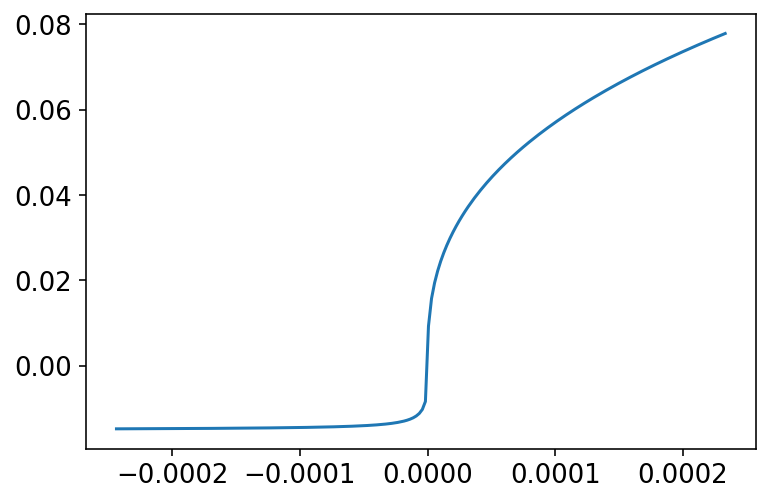

In [238]:
plt.plot(zvec,alpha_vec)

In [240]:
%%timeit
alpha_exact_case_D(zm, xm, 0.03, beta**2)

5.15 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [245]:
%%timeit
alpha_exact(zm, xm, beta**2)

4.01 s ± 237 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [256]:
#alpha_case_B(zvec, 1e-5, 0.99999999)

In [257]:
%%timeit
alpha_case_B(zm, xm, beta**2)

3.89 s ± 570 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [215]:
alpha_exact(zm[0][0], 1e-5, 0.9999999)

array(-0.00012171)

In [196]:
alpha_case_B(zm, 1e-5, 0.9999999)

array([[-0.02066699, -0.02066699, -0.02066699, ..., -0.02066699,
        -0.02066699, -0.02066699],
       [-0.02064863, -0.02064863, -0.02064863, ..., -0.02064863,
        -0.02064863, -0.02064863],
       [-0.02063044, -0.02063044, -0.02063044, ..., -0.02063044,
        -0.02063044, -0.02063044],
       ...,
       [-0.02055223, -0.02055223, -0.02055223, ..., -0.02055223,
        -0.02055223, -0.02055223],
       [-0.02056972, -0.02056972, -0.02056972, ..., -0.02056972,
        -0.02056972, -0.02056972],
       [-0.02058737, -0.02058737, -0.02058737, ..., -0.02058737,
        -0.02058737, -0.02058737]])

In [202]:
alpha_exact(zm[0], 1e-5, 0.9999999)

array([-0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00012171,
       -0.00012171, -0.00012171, -0.00012171, -0.00012171, -0.00

In [198]:
alpha_exact(zm, 1e-5, 0.9999999)

array([[-0.00012171, -0.00012171, -0.00012171, ..., -0.00012171,
        -0.00012171, -0.00012171],
       [-0.00012051, -0.00012051, -0.00012051, ..., -0.00012051,
        -0.00012051, -0.00012051],
       [-0.00011931, -0.00011931, -0.00011931, ..., -0.00011931,
        -0.00011931, -0.00011931],
       ...,
       [ 0.11115208,  0.11115208,  0.11115208, ...,  0.11115208,
         0.11115208,  0.11115208],
       [ 0.11153905,  0.11153905,  0.11153905, ...,  0.11153905,
         0.11153905,  0.11153905],
       [ 0.11192336,  0.11192336,  0.11192336, ...,  0.11192336,
         0.11192336,  0.11192336]])

In [ ]:
@np.vectorize
def alpha_case_D(z, x, beta2):
    """
    Exact alpha calculation using numerical root finding.
    
    For testing only!
    
    Eq. (23) from Ref[1]
    """
    beta = sqrt(beta2)
    f = lambda a: a - beta/2*np.sqrt(x**2 + 4*(1+x)*np.sin(a)**2 ) - z
    
    res = scipy.optimize.root_scalar(f, bracket=(-1,1))
    
    return res.root